In [158]:
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from pathlib import Path
import sys, time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from torch.utils.data import WeightedRandomSampler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Exploration: Baseline Characteristics

In [211]:
label_path = 'D:/nodule/data/labels/'

label = [pd.DataFrame(pd.read_csv(os.path.join(label_path, file), delim_whitespace = True)) for file in os.listdir(label_path)]
df = pd.concat(label, ignore_index = True)
df['types'] = [string.split('/') for string in df['image']]
df['types'] = [string[0] for string in df['types']]
df['image'] = [string.split('/') for string in df['image']]
df['image'] = [string[1][6:-4] for string in df['image']]
len(df[df['label'] == 0])
len(df) - len(df[df['label'] == 0])

1351

In [212]:
class NoduleDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform = None):
        self.data_dir = data_dir
        self.augment = transforms.Compose([
            transforms.Resize(50),
            transforms.RandomResizedCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
        self.transform = transforms.Compose([
            transforms.Resize(50),
            transforms.RandomCrop(32, padding = 2),
            transforms.ToTensor()])
        
        self.images_dir = data_dir / 'images'
        self.labels_dir = data_dir / 'labels'

        self.train_images_dir = self.images_dir 
        self.val_images_dir   = self.images_dir  
        self.test_images_dir  = self.images_dir  

        self.train_labels_file = self.labels_dir  / 'trainlabels.txt'
        self.val_labels_file   = self.labels_dir  / 'vallabels.txt'
        self.test_labels_file  = self.labels_dir  / 'testlabels.txt'

        self.train_data = self._load_data(self.train_images_dir, self.train_labels_file)
        self.val_data   = self._load_data(self.val_images_dir, self.val_labels_file)
        self.test_data  = self._load_data(self.test_images_dir, self.test_labels_file)

    def __getitem__(self, index):
        if index < len(self.train_data):
            images_dir = self.train_images_dir
            data = self.train_data
        elif index < len(self.train_data) + len(self.val_data):
            images_dir = self.val_images_dir
            data = self.val_data
            index -= len(self.train_data)
        else:
            images_dir = self.test_images_dir
            data = self.test_data
            index -= (len(self.train_data) + len(self.val_data))

        img_path = images_dir / data[index][0]
        with open(img_path, 'rb') as f:
            image = Image.open(f).convert('RGB')

        label = data[index][1]
        return self.transform(image), label

    def __len__(self):
        return len(self.train_data) + len(self.val_data) + len(self.test_data)

    def _load_data(self, images_dir, labels_file):
        with open(labels_file, 'r') as f:
            lines = f.readlines()

        data = []
        for line in lines[1:]:
            filename, label = line.strip().split()
            filename = filename 
            label = int(label)
            data.append((filename, label))
        return data

    def get_datasets(self):
        train_dataset = Subset(self, range(len(self.train_data)))
        test_dataset  = Subset(self, range(len(self.train_data),  len(self.train_data) + len(self.test_data)))
        valid_dataset = Subset(self, range(len(self.train_data) + len(self.test_data),   len(self)))
        return train_dataset, test_dataset, valid_dataset

def GET_NODULEDATASET():
    train_indices = list(range(0, len(dataset.train_data)))
    valid_indices = list(range(len(dataset.train_data),  len(dataset.train_data) + len(dataset.val_data)))
    test_indices  = list(range(len(dataset.train_data) + len(dataset.val_data), len(dataset)))

    train_dataset = Subset(dataset, train_indices)
    valid_dataset = Subset(dataset, valid_indices)
    test_dataset  = Subset(dataset, test_indices)
    return train_dataset, valid_dataset, test_dataset

data_dir = Path('D:/nodule/data/')
dataset  = NoduleDataset(data_dir)
class_weights = [1.0, 2.0]
class_samples = [0] * len(class_weights)
for _, label in dataset:
    class_samples[label] += 1
weights = [class_weights[label] / class_samples[label] for _, label in dataset]
sampler = WeightedRandomSampler(weights, len(weights))

train_dataset, valid_dataset, test_dataset = GET_NODULEDATASET()
train_loader  = DataLoader(train_dataset, batch_size = 32, shuffle = True)
valid_loader  = DataLoader(valid_dataset, batch_size = 32, shuffle = False)
test_loader   = DataLoader(test_dataset,  batch_size = 32, shuffle = False)

Label: [0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0]
Class:  Benign Malignant Benign Benign Benign Benign Benign Benign Benign Benign Benign Malignant Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Malignant Benign Benign Benign Benign Benign Malignant Benign Malignant Benign


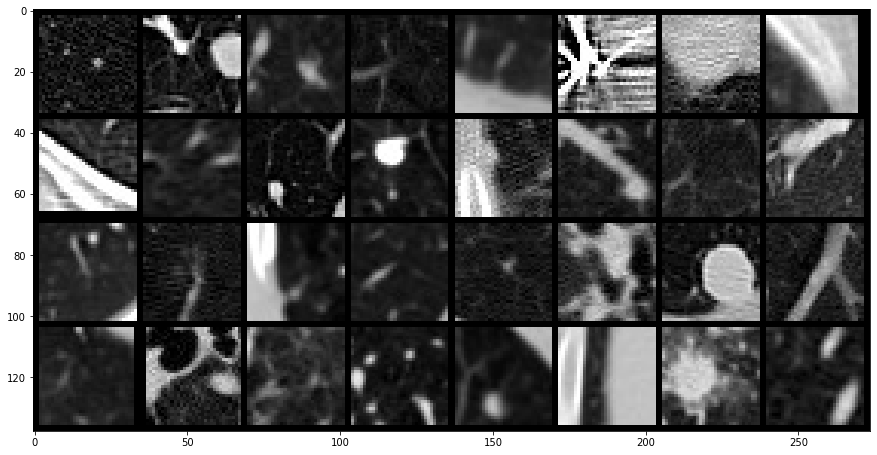

In [199]:
class_names = ['Benign', 'Malignant']
for images, labels in train_loader: 
    break
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))
im = make_grid(images, nrow = 8, ncol = 4)  
plt.figure(figsize=(15, 8))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [202]:
model_vgg19 = torchvision.models.vgg19(weights = True)
model_vgg19.to(device)
print()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [204]:
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model_vgg19.parameters(), lr = learning_rate, eps = 10e-06)

train_losses = []
val_losses = []
for epoch in range(10):
    running_loss = 0.0
    model_vgg19.train()
    for idx, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = model_vgg19(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if idx == 0:
            print('Epoch %2d | Iteration %2d Train Loss: %.5f' % (epoch + 1, idx + 1, running_loss / 100))
            running_loss = 0.0    
        elif idx == 5:
            break
        train_losses.append(loss.item())

    model_vgg19.eval()
    with torch.no_grad():
        val_loss = 0.0
        for val_data in valid_loader:
            val_inputs, val_labels = val_data
            val_outputs = model_vgg19(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
        val_losses.append(val_loss / len(valid_loader))
        print('Epoch %2d | Validation Loss: %.5f' % (epoch + 1, val_loss / len(valid_loader)))

Epoch  1 | Iteration  1 Train Loss: 0.02932
Epoch  1 | Validation Loss: 31.87601
Epoch  2 | Iteration  1 Train Loss: 0.29735
Epoch  2 | Validation Loss: 53.51641
Epoch  3 | Iteration  1 Train Loss: 0.51027
Epoch  3 | Validation Loss: 0.56520
Epoch  4 | Iteration  1 Train Loss: 0.01542
Epoch  4 | Validation Loss: 2.27977
Epoch  5 | Iteration  1 Train Loss: 0.02085
Epoch  5 | Validation Loss: 3.21648
Epoch  6 | Iteration  1 Train Loss: 0.03069
Epoch  6 | Validation Loss: 0.60352
Epoch  7 | Iteration  1 Train Loss: 0.00417
Epoch  7 | Validation Loss: 0.45383
Epoch  8 | Iteration  1 Train Loss: 0.00614
Epoch  8 | Validation Loss: 0.45650
Epoch  9 | Iteration  1 Train Loss: 0.00675
Epoch  9 | Validation Loss: 0.45848
Epoch 10 | Iteration  1 Train Loss: 0.00618
Epoch 10 | Validation Loss: 0.48633


In [210]:
import time
start_time = time.time()

epochs = 10
train_losses, test_losses   = [], []
train_correct, test_correct = [], []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    model_vgg19.train()
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model_vgg19(X_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f'Epoch: {i:2}  Batch: {b:4} [{10*b:6}]  Loss: {loss.item():10.8f}  Accuracy: {trn_corr.item()/(b):7.3f}%')
    train_losses.append(loss)
    train_correct.append(trn_corr)

    model_vgg19.eval()  
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model_vgg19(X_test)

            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

In [70]:
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model_vgg19.parameters(), lr = learning_rate, eps = 10e-06)

losses = []
for epoch in range(10):
    running_loss = 0.0
    for idx, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs, labels
        
        optimizer.zero_grad()
        outputs = model_vgg19(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if idx == 0:
            print('Epoch %2d | Iteration %2d Loss: %.5f' % (epoch + 1, idx + 1, running_loss / 100))
            running_loss = 0.0    
        elif idx == 5:
            break
        losses.append(loss.item())

Epoch  1 | Iteration  1 Loss: 0.12126
Epoch  2 | Iteration  1 Loss: 6.06244
Epoch  3 | Iteration  1 Loss: 0.03650
Epoch  4 | Iteration  1 Loss: 0.05241
Epoch  5 | Iteration  1 Loss: 0.01630
Epoch  6 | Iteration  1 Loss: 0.00935
Epoch  7 | Iteration  1 Loss: 0.00890
Epoch  8 | Iteration  1 Loss: 0.00195
Epoch  9 | Iteration  1 Loss: 0.00617
Epoch 10 | Iteration  1 Loss: 0.00534


In [64]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 46656)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X
    
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 46656)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [58]:
torch.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
